In [1]:
from qiskit import *

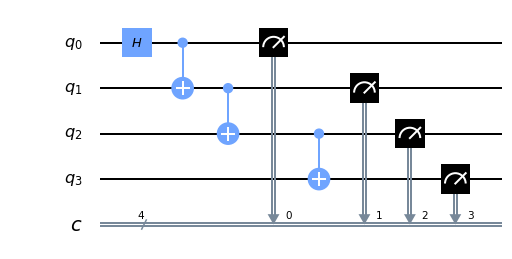

In [3]:
# creating a circuit to later create meas_filer from meas_fitter from CompleteMeasFitter and
# cal_meas_fitter from qiskit.ignis.mitigation.measurement
circuit = QuantumCircuit(4,4)
# applying entanglement between 0 & 1
circuit.h(0)
circuit.cx(0,1)
# applying some CNOT operations
circuit.cx(1,2)
circuit.cx(2,3)
circuit.measure([0,1,2,3], [0,1,2,3])
circuit.draw(output='mpl')

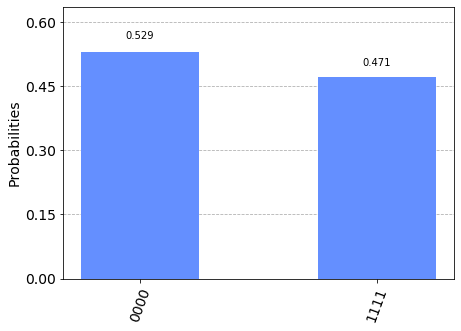

In [4]:
# executing on both simulator and QC
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result() 
from qiskit.visualization import plot_histogram as hg
hg(
result.get_counts()
)

In [8]:
# now for QC first by choosing provider then device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
device = provider.get_backend('ibmqx2')
device_result = execute(circuit, backend=device, shots=1024).result()

ibmqfactory.load_account:WARNING:2020-07-03 18:34:09,355: Credentials are already in use. The existing account in the session will be replaced.


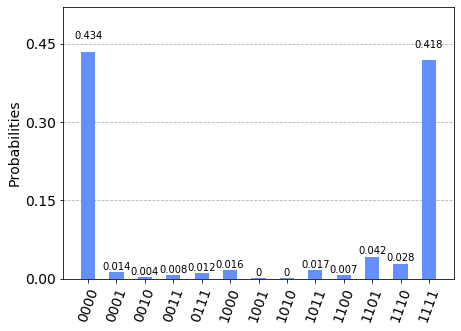

In [9]:
hg(
device_result.get_counts()
)


In [10]:
# now calibrating mitigation errors using qiskit ignis
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
# now assigning qr to circuit and giving circlabel
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], circlabel='measurement_cal')

In [12]:
# now running this on qc
cal_job = execute(cal_circuits, backend=device, shots=8192, optimization_level=0)

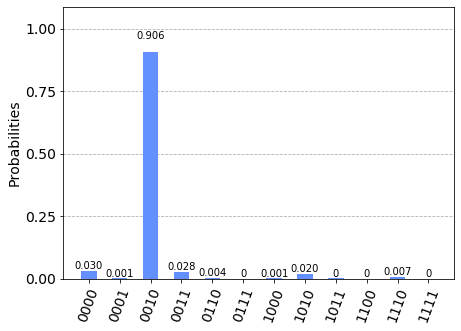

In [13]:
cal_result = cal_job.result()
hg(
cal_result.get_counts(cal_circuits[2])
)

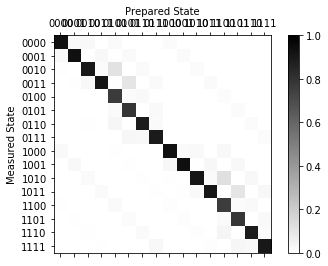

In [14]:
# now working with meas fitter
meas_fitter = CompleteMeasFitter(cal_result, state_labels)
# now plotting calibration
meas_fitter.plot_calibration()

In [15]:
# now getting a filter
meas_filter = meas_fitter.filter

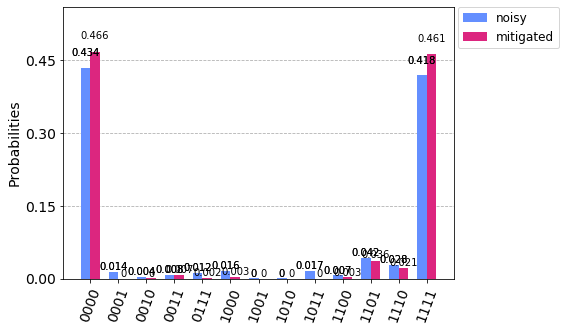

In [17]:
# mitigating measurement errors in the above circuit
mitigated_result = meas_filter.apply(device_result)
hg(
[device_result.get_counts(), mitigated_result.get_counts()], legend=['noisy', 'mitigated']
)

In [21]:
# now creating new circuit and running on it
circuit2 = QuantumCircuit(4,4)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.cx(2,3)
circuit2.measure([0,1,2,3],[0,1,2,3])

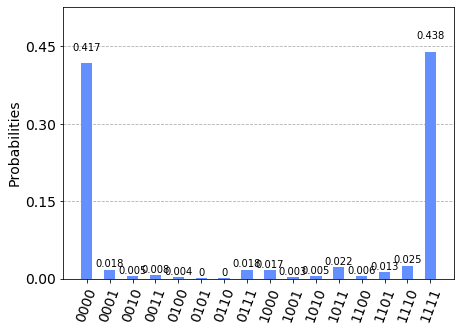

In [22]:
# now running this on QC
device_result2 = execute(circuit2, backend=device, shots=1024).result()
hg(
device_result2.get_counts()
)

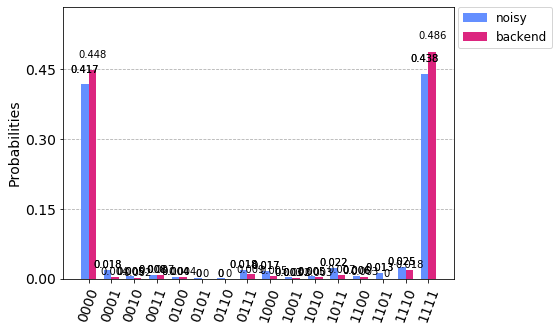

In [24]:
# now applying filter on circuit 2 results
meas_result2 = meas_filter.apply(device_result2)
# now plotting hg
hg(
[device_result2.get_counts(), meas_result2.get_counts()],
legend=['noisy', 'backend']    
)